In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from IPython.display import clear_output
from math import pi

from mpl_toolkits.axes_grid1 import Divider, Size
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from scipy import stats

# Code from Dauxois

In [2]:
N = 32  # Number of moving particles
alpha = 0.25  # Nonlinear parameter
t_max = 10000
dt = 0.1

y0 = np.zeros(2*(N+2))
for i in range(1, N+1):
    a = 1
    y0[i] = a * np.sin(np.pi * i /(N+1))

    #b[I - 1] = a * np.sin(np.pi * N * I / (N + 1))
    #b[I + N - 1] = 0  # Zabusky-Deem init. cond.
    #k = 0.8
    #sk = np.sinh(k) ** 2
    #ek = np.exp(-k)
    #i1 = I - N / 4
    #i2 = i1 - N / 2  # Solitons
    #b[I - 1] = -0.5 / alpha * np.log((1 + np.exp(2 * k * (i1 - 1))) / (1 + np.exp(2 * k * i1)))  # Kink
    #b[I - 1] += 0.5 / alpha * np.log((1 + np.exp(2 * k * (i2 - 1))) / (1 + np.exp(2 * k * i2)))  # Anti-kink
    #b[I + N - 1] = sk * ek / alpha / np.cosh(k * i1) / (np.exp(-k * i1) + np.exp(k * i1) * np.exp(-2 * k))
    #b[I + N - 1] -= sk * ek / alpha / np.cosh(k * i2) / (np.exp(-k * i2) + np.exp(k * i2) * np.exp(-2 * k))

omegak2 = np.zeros(N)
for i in range(N):
    omegak2[i] = 4 * np.sin(np.pi * (i+1) / (2 * N)) ** 2  # Mode Frequencies

def fpu1(y,t):
    disp = y[0:N+2]
    y_dot = y[N+2:]
    y_ddot = (np.roll(disp, 1) + np.roll(disp, -1) -2*disp) +alpha*((disp-np.roll(disp,-1))**2-(np.roll(disp,1)-disp)**2)
    y_dot[0] = 0
    y_dot[N+1] = 0
    #clear_output(wait=True)
    #print(t)
    return np.concatenate((y_dot, y_ddot))

Y = odeint(fpu1, y0, np.arange(0, t_max, dt), rtol=1e-4, atol=1e-4)



In [3]:
TIME = np.arange(0, t_max, dt)*np.sqrt(omegak2[0])/(2*np.pi)
YX = np.zeros((len(TIME), N+1))
YV = np.zeros((len(TIME), N+1))
sXF = np.zeros((len(TIME), 2*(N+1)))
sVF = np.zeros((len(TIME), 2*(N+1)))
Energ = np.zeros((len(TIME), N))
DifY = np.zeros((len(TIME), N))

for IT in range(len(TIME)):
    YX[IT, 0:N+1] = Y[IT, 0:N+1]
    YV[IT, 0:N+1] = Y[IT, N+2:-1]
    YX_in = np.concatenate((YX[IT, :], [0], -YX[IT, :0:-1]))
    YV_in = np.concatenate((YV[IT, :], [0], -YV[IT, :0:-1]))

    sXF[IT, :] = np.fft.fft(YX_in).imag / np.sqrt(2*N)
    sVF[IT, :] = np.fft.fft(YV_in).imag / np.sqrt(2*N)
    Energ[IT, :] = (omegak2 * (sXF[IT, 1:N+1] ** 2) + sVF[IT, 1:N+1] ** 2) / 2
    #for J in range(1, N - 1):
     #   DifY[IT, J - 1] = Y[IT, J + 1] - Y[IT, J]

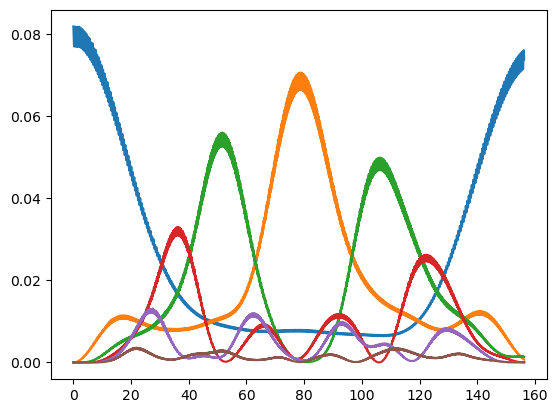

In [4]:
for i in range(6):
    plt.plot(TIME, Energ[:,i])
plt.show()

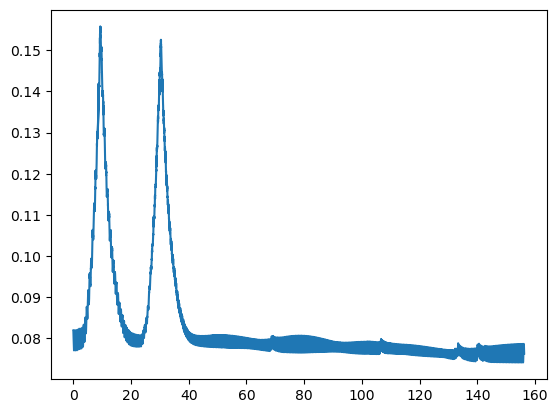

In [5]:
Energ_tot = np.sum(Energ, axis=1)
plt.plot(TIME, Energ_tot)
plt.show()

# By symplectic integration

Consider $N+2$ particles with displacements $u_i$, with clamped ends such that $u_0=u_{N+1}=0$
For convenience, all particles have mass $m=1$

Hamiltonian:
$$\mathcal{H}=\sum_{i=0}^{N-1}\frac{1}{2}p_i^2+\sum_{i=0}^{N-1}\frac{1}{2}K(u_{i+1}-u_i)^2+\frac{K\alpha}{3}\sum_{i=0}^{N-1}\frac{1}{2}K(u_{i+1}-u_i)^3=T(p_i)+U(u_i)$$
Equations of motion:
$$\dot{p}_i=K(u_{i+1}+u_{i-1}-2u_i)+K\alpha[(u_{i+1}-u_i)^2-(u_i-u_{i-1})^2]$$

In [6]:
a_coe = np.array([2+2**(1/3)+2**(-1/3) , 1-2**(1/3)-2**(-1/3) , 1-2**(1/3)-2**(-1/3) , 2+2**(1/3)+2**(-1/3)])/6
b_coe = np.array([0 , 1/(2-2**(1/3)) , 1/(1-2**(2/3)) , 1/(2-2**(1/3))])

In [7]:
class fput:
    def __init__(self, size, k, orders, params, start_x, start_p):
        self.size = size
        self.k = k
        self.orders = orders
        self.params = params
        if len(start_x) == len(start_p):
            if len(start_p) == size:
                self.disp = np.array(start_x)
                self.p_chain = np.array(start_p)
            else:
                raise Exception('Size of initial condition arrays do not match specified system size')
        else:
            raise Exception('The initial conditions for position and momentum are not of the same size')
        self.nfreq2 = 4*(np.sin(np.arange(1, self.size+1)*pi/(2*(self.size))))**2

    def p_c(self, sim_chain):
        p_chain = sim_chain[self.size+2:]
        p_chain[0] = 0
        p_chain[-1] = 0
        return p_chain

    def force_c(self, sim_chain):
        disps = sim_chain[0:self.size+2]
        force = self.k*(np.roll(disps, 1) + np.roll(disps, -1) - 2*disps)
        for i in range(len(self.orders)):
            non_lin_order = self.orders[i]-1
            non_lin_const = self.params[i]
            force += self.k*non_lin_const*(-(disps-np.roll(disps, -1))**non_lin_order + (np.roll(disps, 1)-disps)**non_lin_order)
        return force

    def propagate_clamped(self, step):                                                                # Input: chain without clamped ends
        sim_chain = np.concatenate(([0], self.disp, [0,0], self.p_chain, [0]))
        for i in range(4):
            sim_chain += np.concatenate((np.zeros(self.size+2), b_coe[i]*step*self.force_c(sim_chain)))
            sim_chain += np.concatenate((a_coe[i]*step*self.p_c(sim_chain) , np.zeros(self.size+2) ))
        self.disp = sim_chain[1:self.size+1]
        self.p_chain = sim_chain[self.size+3:2*self.size+3]

    def force_p(self, sim_chain):
        disps = sim_chain[0:self.size]
        force = self.k*(np.roll(disps, 1) + np.roll(disps, -1) - 2*disps)
        for i in range(len(self.orders)):
            non_lin_order = self.orders[i]-1
            non_lin_const = self.params[i]
            force += self.k*non_lin_const*(-(disps-np.roll(disps, -1))**non_lin_order + (np.roll(disps, 1)-disps)**non_lin_order)
        return force

    def propagate_periodic(self, step):
        sim_chain = np.concatenate((self.disp, self.p_chain))
        for i in range(4):
            sim_chain += np.concatenate((np.zeros(self.size), b_coe[i]*step*self.force_p(sim_chain)))
            sim_chain += np.concatenate((a_coe[i]*step*sim_chain[self.size:] , np.zeros(self.size) ))
        self.disp = sim_chain[0:self.size]
        self.p_chain = sim_chain[self.size:]

    def mode_energies_c(self):
        x_input = np.concatenate(([0],self.disp, [0], -self.disp[::-1]))
        v_input = np.concatenate(([0],self.p_chain, [0], -self.p_chain[::-1]))
        modes_x = np.fft.fft(x_input)[1:self.size+1].imag/np.sqrt(2*(self.size+1))
        modes_v = np.fft.fft(v_input)[1:self.size+1].imag/np.sqrt(2*(self.size+1))
        return (modes_v**2 + self.nfreq2*modes_x**2)/2

    def mode_energies_p(self):
        alt_array = np.tile([1, -1], int(self.size/2))
        x_fft = np.fft.fft(self.disp)
        v_fft = np.fft.fft(self.p_chain)
        modes_x = np.concatenate((-x_fft[1:int(self.size/2)].imag*np.sqrt(2), [np.sum(self.disp)] , x_fft[int(self.size/2)+1:self.size].real*np.sqrt(2), [np.sum(alt_array*self.disp)]))/np.sqrt(self.size)
        modes_v = np.concatenate((-v_fft[1:int(self.size/2)].imag*np.sqrt(2), [np.sum(self.p_chain)] , v_fft[int(self.size/2)+1:self.size].real*np.sqrt(2), [np.sum(alt_array*self.p_chain)]))/np.sqrt(self.size)
        return (modes_v**2 + self.nfreq2*modes_x**2)/2

    def tot_energy(self):
        tot_energy = np.sum(self.p_chain)**2/2
        sim_chain = np.concatenate(([0], self.disp))
        tot_energy += self.k*0.5*np.sum((np.roll(sim_chain, 1)-sim_chain)**2)
        for j in range(len(self.orders)):
            non_lin_order = self.orders[j]
            non_lin_const = self.params[j]
            tot_energy += (self.k*non_lin_const/non_lin_order)*np.sum((np.roll(sim_chain, 1)-sim_chain)**non_lin_order)
        return tot_energy

## Original experiment
Starting in only the first mode, with clamped boundary conditions

In [8]:
start = time.time()
N = 32
fput_original = fput(N, 1, [3], [0.25], np.sin(pi*np.arange(1, N+1)/(N+1)), np.zeros(N))

t_max = 10000
step = 0.1

energies = np.zeros((int(t_max/step)+1, N))
configs = np.zeros((int(t_max/step)+1, N))
chain_p = np.zeros((int(t_max/step)+1, N))
energies[0, :] = fput_original.mode_energies_c()
configs[0, :] = fput_original.disp
chain_p[0, :] = fput_original.p_chain

for i in range(1, int(t_max/step)+1):
    #clear_output(wait=True)
    #print(i*step)
    #print(fput_original.disp)
    fput_original.propagate_clamped(step)
    configs[i, :] = fput_original.disp
    energies[i, :] = fput_original.mode_energies_c()
    chain_p[i, :] = fput_original.p_chain

end = time.time()
print(end-start)

16.73389768600464


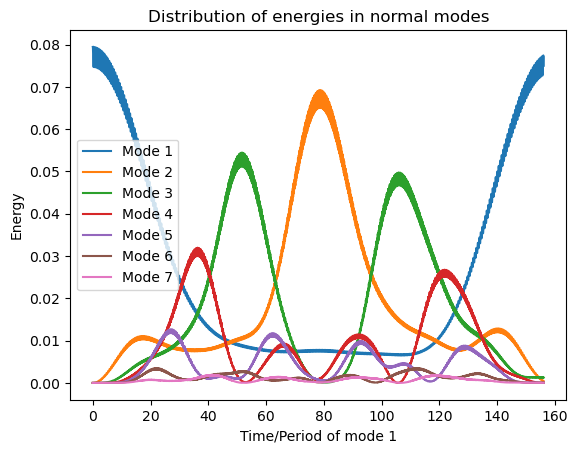

In [9]:
time_in_cycles = np.arange(0, t_max+step, step)*np.sqrt(fput_original.nfreq2[0])/(2*pi)

for i in np.arange(7):
    plt.plot(time_in_cycles, energies[:, i], label='Mode '+str(i+1))
plt.legend()
plt.title('Distribution of energies in normal modes')
plt.xlabel('Time/Period of mode 1')
plt.ylabel('Energy')
plt.show()

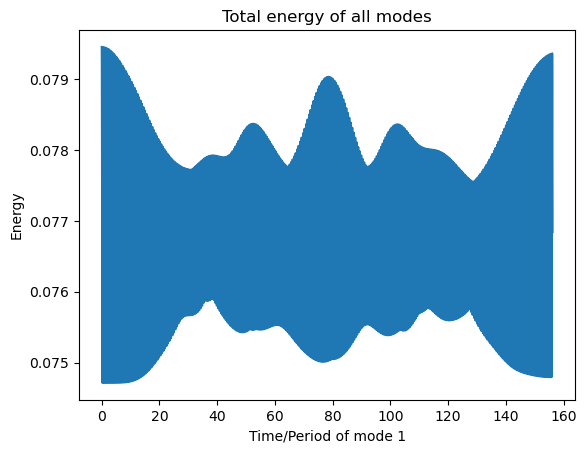

In [11]:
plt.plot(time_in_cycles, np.sum(energies, axis=1))
plt.title('Total energy of all modes')
plt.xlabel('Time/Period of mode 1')
plt.ylabel('Energy')
plt.show()

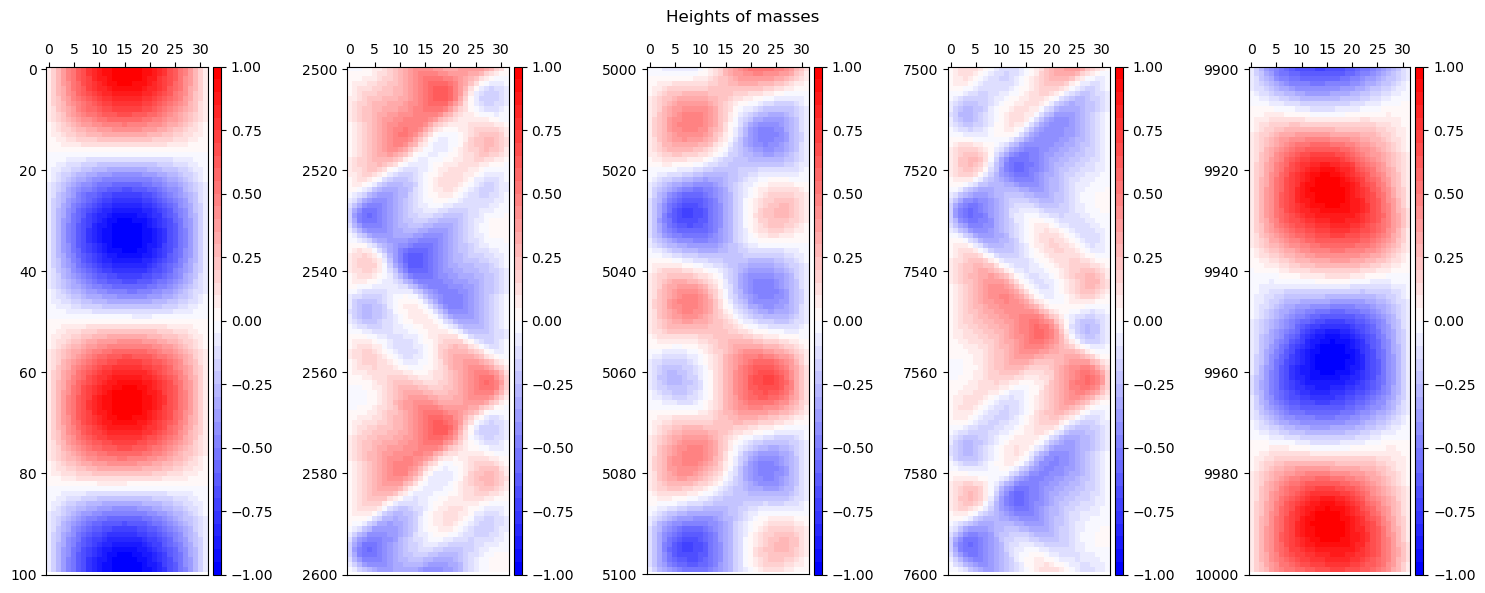

In [85]:
duration = 100
time_gap = 1
start_times = [0, 2500, 5000, 7500, 9900]

fig, axs = plt.subplots(1,len(start_times), figsize=(len(start_times)*3, 6))
colors = plt.get_cmap('bwr', 40)

for i in range(len(start_times)):
    start = int(start_times[i]/step)
    end = int((start_times[i]+duration)/step)
    #mat1 = axs[i].matshow(DifY[start:end:int(time_gap/step), :], aspect='equal')
    mat1 = axs[i].matshow(configs[start:end:int(time_gap/step), :],cmap=colors, aspect='equal', vmin=-1, vmax=1)
    axs[i].xaxis.set_ticks_position('top')
    axs[i].set_yticks(np.arange(0, 120, 20), np.arange(0, 120, 20)+start_times[i])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(mat1, cax=cax, orientation='vertical')
fig.suptitle('Heights of masses')
plt.tight_layout()
plt.show()

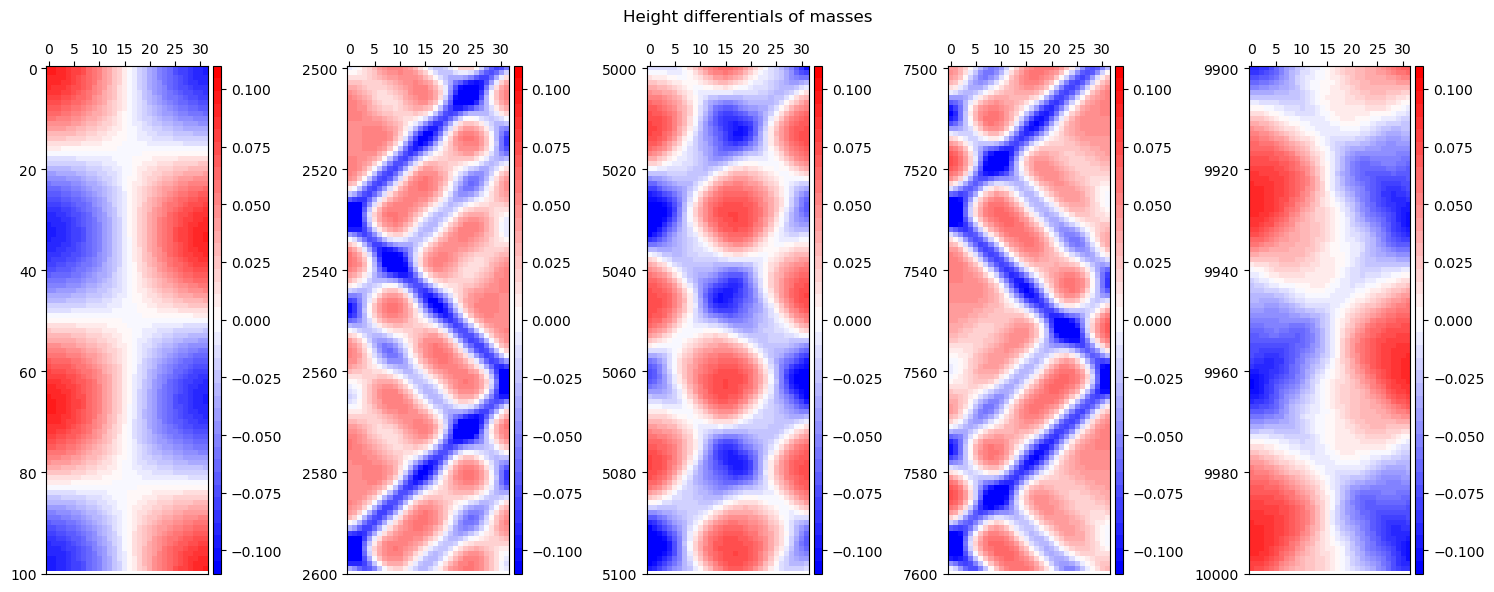

In [86]:
DifY = np.zeros((int(t_max/step), fput_original.size))
colors = plt.get_cmap('bwr', 40)

for i in range(int(t_max/step)):
    sim_chain = np.concatenate(([0], configs[i,:]))
    DifY[i, :] = (-np.roll(sim_chain,1)+sim_chain)[1:]

duration = 100
time_gap = 1
start_times = [0, 2500, 5000, 7500, 9900]

fig, axs = plt.subplots(1,len(start_times), figsize=(len(start_times)*3, 6))

for i in range(len(start_times)):
    start = int(start_times[i]/step)
    end = int((start_times[i]+duration)/step)
    mat1 = axs[i].matshow(DifY[start:end:int(time_gap/step), :], aspect='equal', cmap=colors, vmin=-0.11, vmax=0.11)
    #mat1 = axs[i].matshow(configs[start:end:int(time_gap/step), :],cmap=colors, aspect='equal', vmin=-1, vmax=1)
    axs[i].xaxis.set_ticks_position('top')
    axs[i].set_yticks(np.arange(0, 120, 20), np.arange(0, 120, 20)+start_times[i])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(mat1, cax=cax, orientation='vertical')
fig.suptitle('Height differentials of masses')
plt.tight_layout()
plt.show()

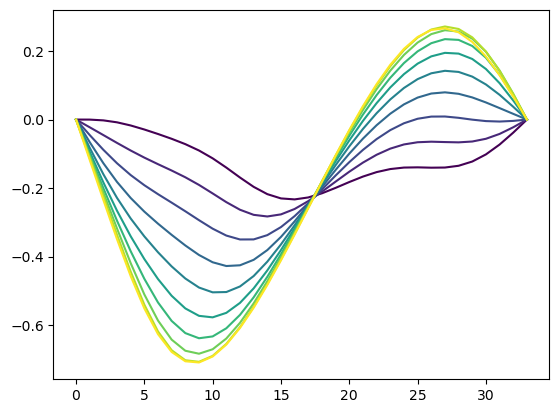

In [91]:
times = np.arange(5020, 5030, 1)

cmap = plt.get_cmap('viridis')
plot_colors = cmap(np.linspace(0, 1, len(times)))
for i in range(len(times)):
    t_index = int(times[i]/step)
    plt.plot(np.concatenate(([0],np.arange(1, N+1),[N+1])), np.concatenate(([0],configs[t_index,: ],[0])), color=plot_colors[i], label='t='+str(times[i]))
    #print('Energy of first mode: ', energies[t_index, 0], ' Energy of all modes: ',np.sum(energies[t_index, :]))
#plt.legend(loc='upper center', ncols=5)
plt.show()

## With periodic boundary conditions
All energy initially in first mode

In [92]:
N= 32

fput_periodic = fput(N, 1, [3], [0.25], np.sin(pi*np.arange(N)/N), np.zeros(32))

fput_periodic.nfreq2 = 4*(np.sin(np.arange(1,N+1)*pi/N))**2

t_max = 10000
step = 0.1

energies = np.zeros((int(t_max/step)+1, N))
alt_energies = np.zeros(int(t_max/step)+1)
configs = np.zeros((int(t_max/step)+1, N))
chain_p = np.zeros((int(t_max/step)+1, N))
alt_energies[0] = fput_periodic.tot_energy()
energies[0, :] = fput_periodic.mode_energies_p()
configs[0, :] = fput_periodic.disp
chain_p[0, :] = fput_periodic.p_chain

for i in range(1, int(t_max/step)+1):
    #clear_output(wait=True)
    #print(i*step)
    #print(fput_periodic.disp)
    fput_periodic.propagate_periodic(step)
    energies[i, :] = fput_periodic.mode_energies_p()
    alt_energies[i] = fput_periodic.tot_energy()
    configs[i, :] = fput_periodic.disp
    chain_p[i, :] = fput_periodic.p_chain

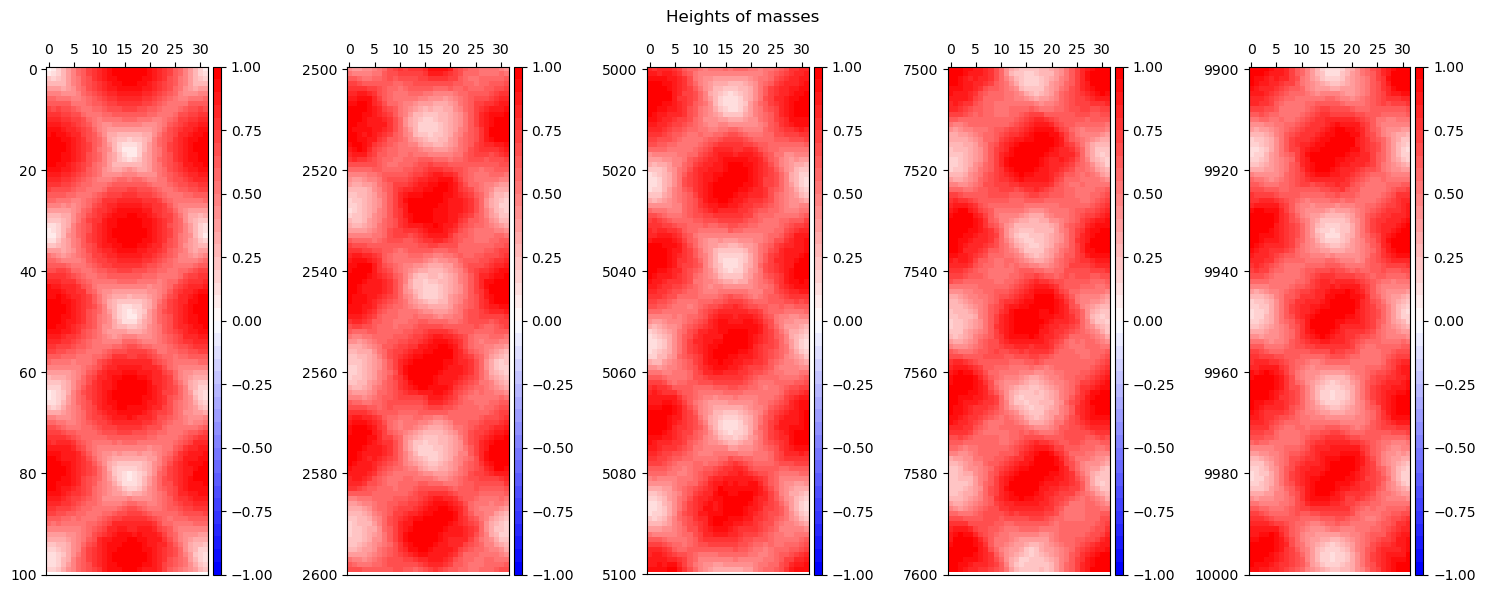

In [93]:
duration = 100
time_gap = 1
start_times = [0, 2500, 5000, 7500, 9900]

fig, axs = plt.subplots(1,len(start_times), figsize=(len(start_times)*3, 6))
colors = plt.get_cmap('bwr', 40)

for i in range(len(start_times)):
    start = int(start_times[i]/step)
    end = int((start_times[i]+duration)/step)
    #mat1 = axs[i].matshow(DifY[start:end:int(time_gap/step), :], aspect='equal')
    mat1 = axs[i].matshow(configs[start:end:int(time_gap/step), :],cmap=colors, aspect='equal', vmin=-1, vmax=1)
    axs[i].xaxis.set_ticks_position('top')
    axs[i].set_yticks(np.arange(0, 120, 20), np.arange(0, 120, 20)+start_times[i])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(mat1, cax=cax, orientation='vertical')
fig.suptitle('Heights of masses')
plt.tight_layout()
plt.show()

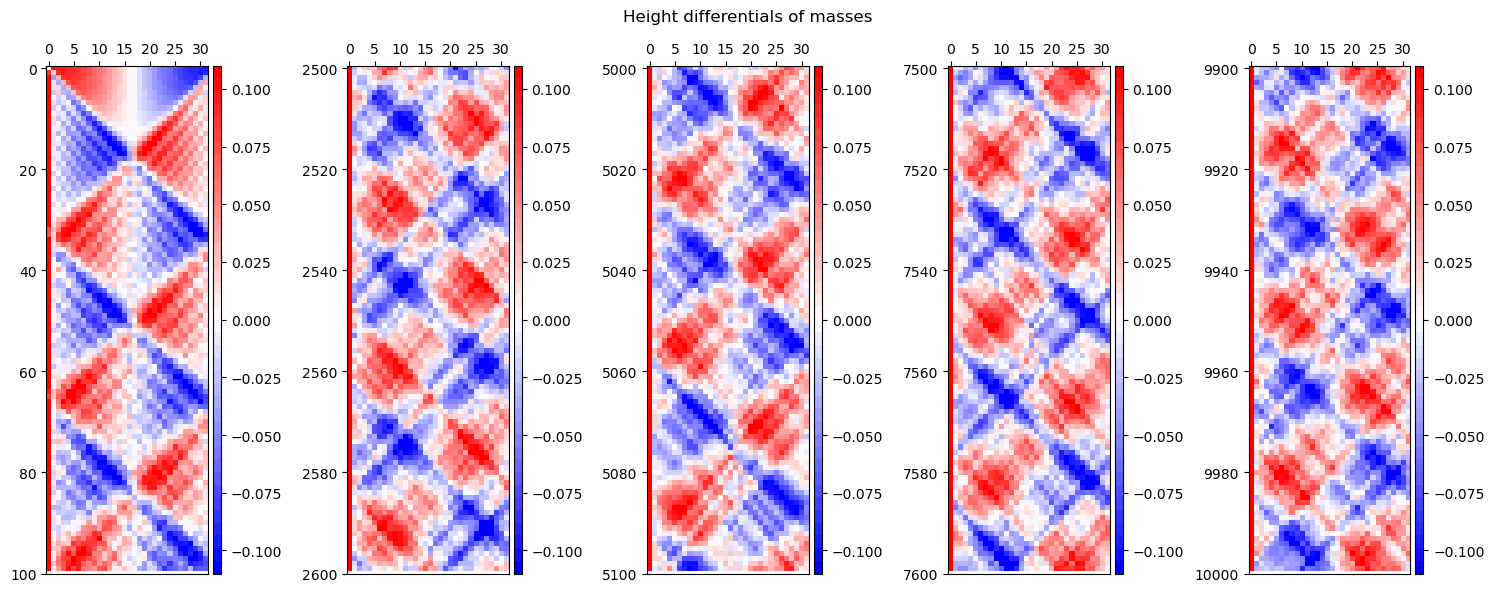

In [94]:
DifY = np.zeros((int(t_max/step), fput_original.size))
colors = plt.get_cmap('bwr', 40)

for i in range(int(t_max/step)):
    sim_chain = np.concatenate(([0], configs[i,:]))
    DifY[i, :] = (-np.roll(sim_chain,1)+sim_chain)[1:]

duration = 100
time_gap = 1
start_times = [0, 2500, 5000, 7500, 9900]

fig, axs = plt.subplots(1,len(start_times), figsize=(len(start_times)*3, 6))

for i in range(len(start_times)):
    start = int(start_times[i]/step)
    end = int((start_times[i]+duration)/step)
    mat1 = axs[i].matshow(DifY[start:end:int(time_gap/step), :], aspect='equal', cmap=colors, vmin=-0.11, vmax=0.11)
    #mat1 = axs[i].matshow(configs[start:end:int(time_gap/step), :],cmap=colors, aspect='equal', vmin=-1, vmax=1)
    axs[i].xaxis.set_ticks_position('top')
    axs[i].set_yticks(np.arange(0, 120, 20), np.arange(0, 120, 20)+start_times[i])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(mat1, cax=cax, orientation='vertical')
fig.suptitle('Height differentials of masses')
plt.tight_layout()
plt.show()

Energy of first mode:  8.89074047362256e-34  Energy of all modes:  25.973459922278177
Energy of first mode:  3.459020684356804e-07  Energy of all modes:  25.973585736564374
Energy of first mode:  9.99413018732569e-07  Energy of all modes:  25.97354873268978
Energy of first mode:  1.5627566186158792e-06  Energy of all modes:  25.973475427390085
Energy of first mode:  1.9171196127320163e-06  Energy of all modes:  25.97361192199911
Energy of first mode:  2.0585216116580773e-06  Energy of all modes:  25.973507773764577
Energy of first mode:  2.091838285060007e-06  Energy of all modes:  25.973504613901525
Energy of first mode:  2.1113995369625875e-06  Energy of all modes:  25.973607993919057
Energy of first mode:  2.1359596470187374e-06  Energy of all modes:  25.973471368618096
Energy of first mode:  2.1691312682078895e-06  Energy of all modes:  25.97354322875221


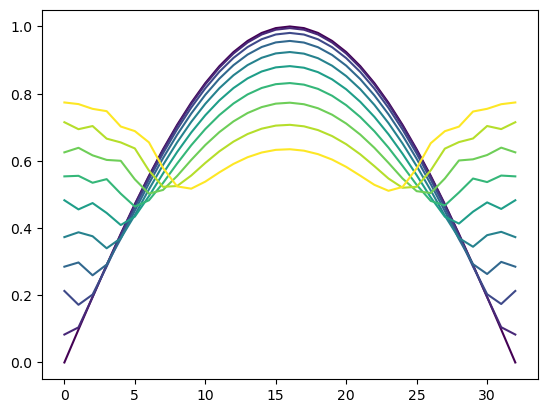

In [57]:
times = np.arange(0, 10, 1)

cmap = plt.get_cmap('viridis')
plot_colors = cmap(np.linspace(0, 1, len(times)))
for i in range(len(times)):
    t_index = int(times[i]/step)
    plt.plot(np.arange(0, N+1), np.concatenate((configs[t_index,: ], [configs[t_index, 0]])), color=plot_colors[i], label='t='+str(times[i]))
    print('Energy of first mode: ', energies[t_index, 0], ' Energy of all modes: ',np.sum(energies[t_index, :]))
#plt.legend(loc='upper center', ncols=5)
plt.show()

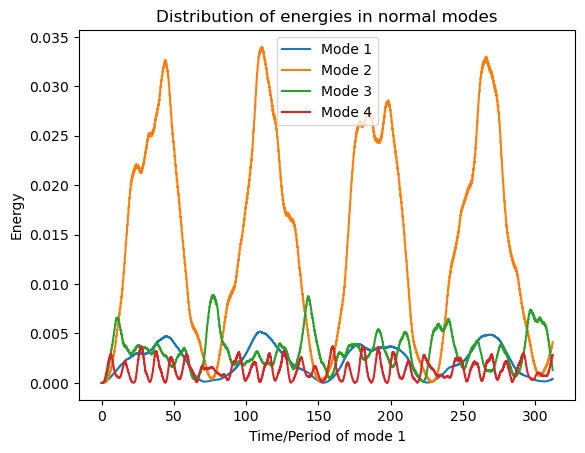

In [58]:
time_in_cycles = np.arange(0, t_max+step, step)*np.sqrt(fput_periodic.nfreq2[0])/(2*pi)

for i in range(4):
    plt.plot(time_in_cycles, energies[:, i], label='Mode '+str(i+1))
plt.legend()
plt.title('Distribution of energies in normal modes')
plt.xlabel('Time/Period of mode 1')
plt.ylabel('Energy')
plt.show()

## Soliton initial condition (clamped)

In [66]:
def kink(x, l, a, t):
    return np.log( (1+np.exp(2*l*(x-1-a) +t*np.sinh(l)))/ (1+np.exp(2*l*(x-a)+t*np.sinh(l))) )/(2*alpha)
def antikink(x,l,a, t):
    return -np.log( (1+np.exp(2*l*(x-1-a)-t*np.sinh(l)))/ (1+np.exp(2*l*(x-a)-t*np.sinh(l))) )/(2*alpha)

In [67]:
N=128
alpha=0.25
V_order = 3

latt = np.arange(0, N)
a = 60
b = 68
l = 1

soliton = fput(N, 1, [V_order], [alpha], kink(latt, l, a, 0)+antikink(latt, l, b, 0), np.zeros(N))

t_max = 1000
step = 0.01

configs = np.zeros((int(t_max/step)+1, N))
configs[0, :] = soliton.disp

for i in range(1, int(t_max/step)+1):
    #clear_output(wait=True)
    #print(i*step)
    #print(fput_periodic.disp)
    soliton.propagate_clamped(step)
    configs[i, :] = soliton.disp

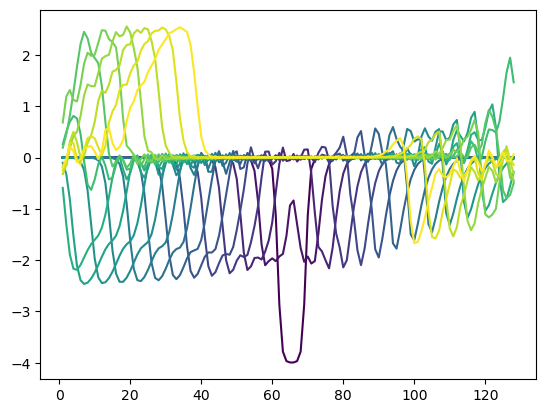

In [68]:
times = np.arange(0, 100, 5)

cmap = plt.get_cmap('viridis')
plot_colors = cmap(np.linspace(0, 1, len(times)))
for i in range(len(times)):
    t_index = int(times[i]/step)
    plt.plot(np.arange(1, N+1), configs[t_index,: ], color=plot_colors[i], label='t='+str(times[i]))
    #plt.plot(np.arange(1, 2*N+1), np.concatenate((configs[t_index,: ], configs[t_index, :])), color=plot_colors[i], label='t='+str(times[i]))
#plt.legend(loc='upper center', ncols=5)
plt.show()

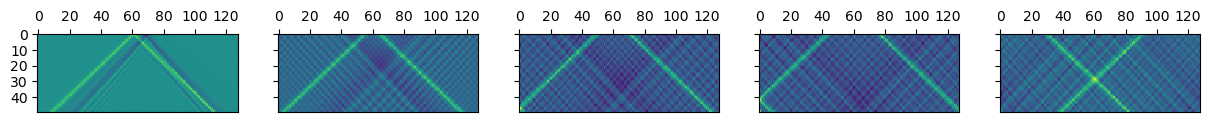

In [69]:
DifY = np.zeros((int(t_max/step), soliton.size))
for i in range(int(t_max/step)):
    DifY[i, :] = np.roll(configs[i,:],1)-configs[i,:]

duration = 100
time_gap = 1
start_times = [0, 250, 500, 750, 950]

fig, axs = plt.subplots(1,len(start_times), figsize=(len(start_times)*3, 15), sharey=True)

for i in range(len(start_times)):
    start = int(start_times[i]/step)
    end = int((start_times[i]+duration)/step)
    axs[i].matshow(DifY[start:end:int(time_gap/step), :], aspect='equal')
    axs[i].xaxis.set_ticks_position('top')
plt.show()

## Soliton initial condition (periodic)

In [70]:
N=128
alpha=0.25
V_order = 3

latt = np.arange(0, N)
a = 60
b = 68
l = 1

soliton = fput(N, 1, [V_order], [alpha], kink(latt, l, a, 0), np.zeros(N))

t_max = 1000
step = 0.01

configs = np.zeros((int(t_max/step)+1, N))
configs[0, :] = soliton.disp

for i in range(1, int(t_max/step)+1):
    #clear_output(wait=True)
    #print(i*step)
    #print(fput_periodic.disp)
    soliton.propagate_periodic(step)
    configs[i, :] = soliton.disp

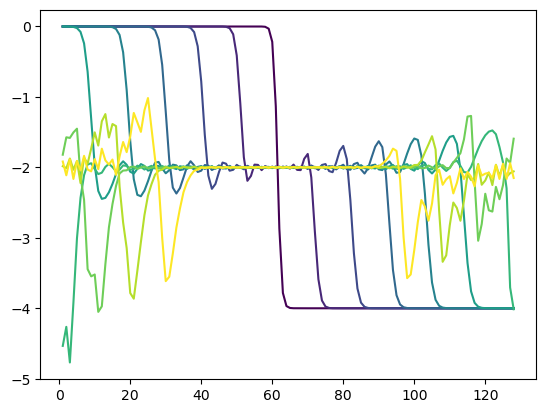

In [74]:
times = np.arange(0, 100, 10)

cmap = plt.get_cmap('viridis')
plot_colors = cmap(np.linspace(0, 1, len(times)))
for i in range(len(times)):
    t_index = int(times[i]/step)
    plt.plot(np.arange(1, N+1), configs[t_index,: ], color=plot_colors[i], label='t='+str(times[i]))
    #plt.plot(np.arange(1, 2*N+1), np.concatenate((configs[t_index,: ], configs[t_index, :])), color=plot_colors[i], label='t='+str(times[i]))
#plt.legend(loc='upper center', ncols=5)
plt.show()

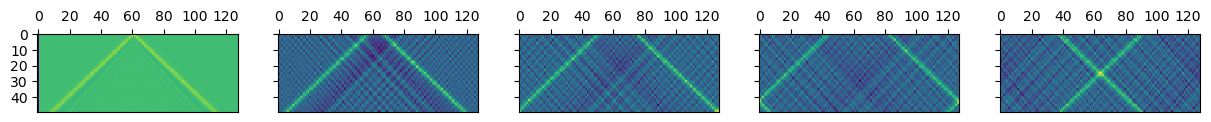

In [72]:
DifY = np.zeros((int(t_max/step), soliton.size))
for i in range(int(t_max/step)):
    DifY[i, :] = np.roll(configs[i,:],1)-configs[i,:]

duration = 100
time_gap = 1
start_times = [0, 250, 500, 750, 950]

fig, axs = plt.subplots(1,len(start_times), figsize=(len(start_times)*3, 15), sharey=True)

for i in range(len(start_times)):
    start = int(start_times[i]/step)
    end = int((start_times[i]+duration)/step)
    axs[i].matshow(DifY[start:end:int(time_gap/step), :], aspect='equal')
    axs[i].xaxis.set_ticks_position('top')
plt.show()

## Zabusky-Deem
All energy in highest energy mode

In [75]:
N = 128
fput_ZD = fput(N, 1, [3], [0.25], 0.1*np.sin(pi*N*np.arange(1, N+1)/(N+1)), np.zeros(N))

t_max = 100000
step = 0.1

energies = np.zeros((int(t_max/step)+1, N))
configs = np.zeros((int(t_max/step)+1, N))
alt_energies = np.zeros(int(t_max/step)+1)
energies[0, :] = fput_ZD.mode_energies_c()
configs[0, :] = fput_ZD.disp

for i in range(1, int(t_max/step)+1):
    #clear_output(wait=True)
    #print(i*step)
    #print(fput_original.disp)
    fput_ZD.propagate_clamped(step)
    configs[i, :] = fput_ZD.disp
    energies[i, :] = fput_ZD.mode_energies_c()

Energy of first mode:  7.291532879408498e-35  Energy of all modes:  1.289999999999995
Energy of first mode:  2.47267005311611e-33  Energy of all modes:  1.289722831976677
Energy of first mode:  7.731518308481986e-33  Energy of all modes:  1.2899545982723237
Energy of first mode:  1.1502298550033145e-33  Energy of all modes:  1.2906329989754888
Energy of first mode:  2.299225015438397e-32  Energy of all modes:  1.289684598322304
Energy of first mode:  1.1910761203600773e-31  Energy of all modes:  1.2908797763368225
Energy of first mode:  1.659251837415741e-31  Energy of all modes:  1.2910993365045078
Energy of first mode:  3.448477484174286e-31  Energy of all modes:  1.2896737556357059
Energy of first mode:  4.35172754769019e-31  Energy of all modes:  1.291188940796352
Energy of first mode:  4.829170577819964e-31  Energy of all modes:  1.2903723173958206


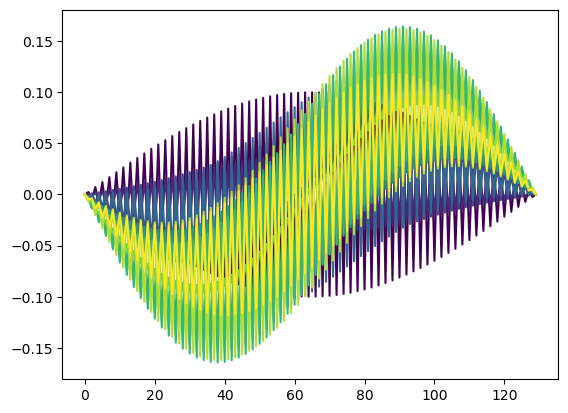

In [76]:
times = np.arange(0, 100, 10)

cmap = plt.get_cmap('viridis')
plot_colors = cmap(np.linspace(0, 1, len(times)))
for i in range(len(times)):
    t_index = int(times[i]/step)
    plt.plot(np.concatenate(([0],np.arange(1, N+1),[N+1])), np.concatenate(([0],configs[t_index,: ],[0])), color=plot_colors[i], label='t='+str(times[i]))
    print('Energy of first mode: ', energies[t_index, 0], ' Energy of all modes: ',np.sum(energies[t_index, :]))
#plt.legend(loc='upper center', ncols=5)
plt.show()

/home/john/anaconda3/envs/scientific/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


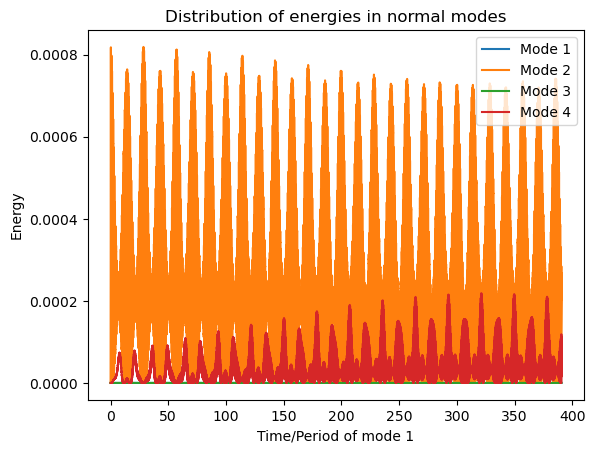

In [77]:
time_in_cycles = np.arange(0, t_max+step, step)*np.sqrt(fput_ZD.nfreq2[0])/(2*pi)

for i in [0,1,2,3]:
    plt.plot(time_in_cycles, energies[:, i], label='Mode '+str(i+1))
plt.legend()
plt.title('Distribution of energies in normal modes')
plt.xlabel('Time/Period of mode 1')
plt.ylabel('Energy')
plt.show()

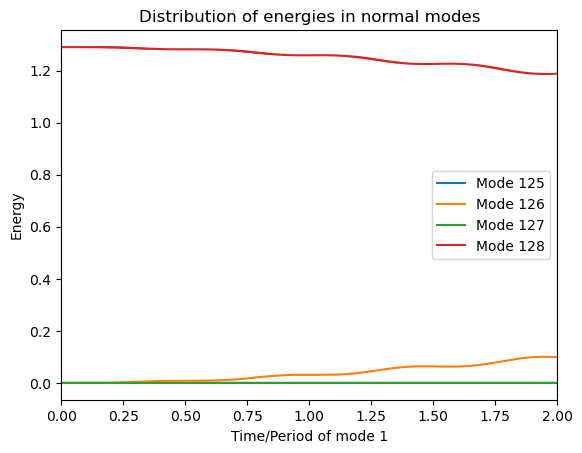

In [78]:
time_in_cycles = np.arange(0, t_max+step, step)*np.sqrt(fput_ZD.nfreq2[0])/(2*pi)

for i in np.arange(124, 128):
    plt.plot(time_in_cycles, energies[:, i], label='Mode '+str(i+1))
plt.legend()
plt.title('Distribution of energies in normal modes')
plt.xlabel('Time/Period of mode 1')
plt.ylabel('Energy')
plt.xlim([0,2])
plt.show()

## Quartic potential

In [75]:
N = 32
fput_quartic = fput(N, 1, [4], [8], np.sin(pi*np.arange(1, N+1)/(N+1)), np.zeros(N))

t_max = 5000
step = 0.1

energies = np.zeros((int(t_max/step)+1, N))
configs = np.zeros((int(t_max/step)+1, N))
energies[0, :] = fput_quartic.mode_energies_c()
configs[0, :] = fput_quartic.disp

for i in range(1, int(t_max/step)+1):
    #clear_output(wait=True)
    #print(i*step)
    #print(fput_original.disp)
    fput_quartic.propagate_clamped(step)
    configs[i, :] = fput_quartic.disp
    energies[i, :] = fput_quartic.mode_energies_c()

Energy of first mode:  0.07945200990875136  Energy of all modes:  0.07945200990875136
Energy of first mode:  0.07911133318778199  Energy of all modes:  0.0794949658148367
Energy of first mode:  0.07793762125560082  Energy of all modes:  0.07926977129772804
Energy of first mode:  0.07584746187139416  Energy of all modes:  0.07847287589368188
Energy of first mode:  0.0731137440093261  Energy of all modes:  0.07757204966333738
Energy of first mode:  0.07017023809745795  Energy of all modes:  0.07712058492287341
Energy of first mode:  0.0672891796968387  Energy of all modes:  0.07712834156291676
Energy of first mode:  0.06443090066170987  Energy of all modes:  0.07744970709989316
Energy of first mode:  0.061195049109950134  Energy of all modes:  0.07793540519603574
Energy of first mode:  0.056742063718485  Energy of all modes:  0.07780116051687652
Energy of first mode:  0.05229987955617944  Energy of all modes:  0.07860399799039582
Energy of first mode:  0.047512200693721994  Energy of all

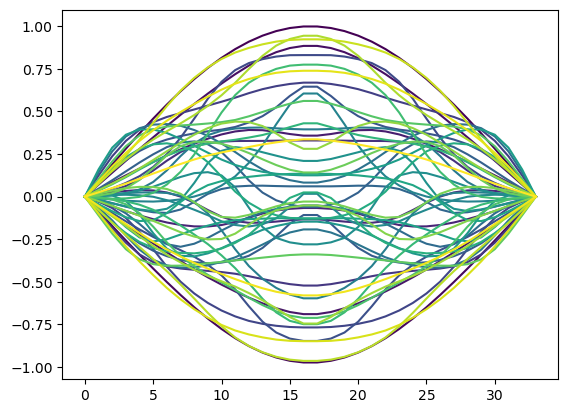

In [76]:
times = np.arange(0, 5000, 100)

cmap = plt.get_cmap('viridis')
plot_colors = cmap(np.linspace(0, 1, len(times)))
for i in range(len(times)):
    t_index = int(times[i]/step)
    plt.plot(np.concatenate(([0],np.arange(1, N+1),[N+1])), np.concatenate(([0],configs[t_index,: ],[0])), color=plot_colors[i], label='t='+str(times[i]))
    print('Energy of first mode: ', energies[t_index, 0], ' Energy of all modes: ',np.sum(energies[t_index, :]))
#plt.legend(loc='upper center', ncols=5)
plt.show()

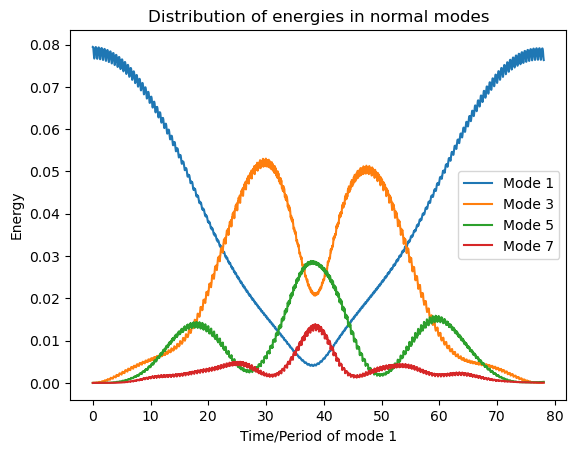

In [78]:
time_in_cycles = np.arange(0, t_max+step, step)*np.sqrt(fput_quartic.nfreq2[0])/(2*pi)

for i in [0, 2, 4, 6]:
    plt.plot(time_in_cycles, energies[:, i], label='Mode '+str(i+1))
plt.legend()
plt.title('Distribution of energies in normal modes')
plt.xlabel('Time/Period of mode 1')
plt.ylabel('Energy')
plt.show()

## Scaling of simulation time by size

In [12]:
N_range = np.arange(100, 6100, 100)
times = []
#energies = {}

t_max = 2500
step = 0.1

for N in N_range:
    start = time.time()
    fput_N = fput(N, 1, [3], [0.25], np.sin(pi*np.arange(1, N+1)/(N+1)), np.zeros(N))
    #energies[N] = np.zeros((int(t_max/step)+1, N))
    #energies[N][0, :] = fput_N.mode_energies_c()
    for i in range(1, int(t_max/step)+1):
        fput_N.propagate_clamped(step)
        #energies[N][i, :] = fput_N.mode_energies_c()
    end = time.time()
    times.append(end-start)
    print(str(N)+'  '+str(end-start))

100  3.6122756004333496
200  3.869802951812744
300  4.007878303527832
400  3.9981086254119873
500  4.316990375518799
600  4.374216794967651
700  4.313194990158081
800  4.492173433303833
900  4.630275249481201
1000  4.8874733448028564
1100  4.660816431045532
1200  4.750451326370239
1300  4.883408308029175
1400  4.97576904296875
1500  4.944224119186401
1600  5.157163381576538
1700  5.0253167152404785
1800  5.108007431030273
1900  5.00457501411438
2000  5.271852970123291
2100  5.377910137176514
2200  5.331351280212402
2300  5.458249807357788
2400  5.348089218139648
2500  5.617029190063477
2600  5.528399467468262
2700  5.7575953006744385
2800  5.557508945465088
2900  5.932423830032349
3000  6.094859838485718
3100  5.983266830444336
3200  6.2093071937561035
3300  5.928659677505493
3400  6.366880178451538
3500  6.290820121765137
3600  6.402318239212036
3700  6.061306953430176
3800  6.604371070861816
3900  6.510949373245239
4000  6.7178075313568115
4100  6.38566255569458
4200  6.8949835300445

R-squared: 0.985720


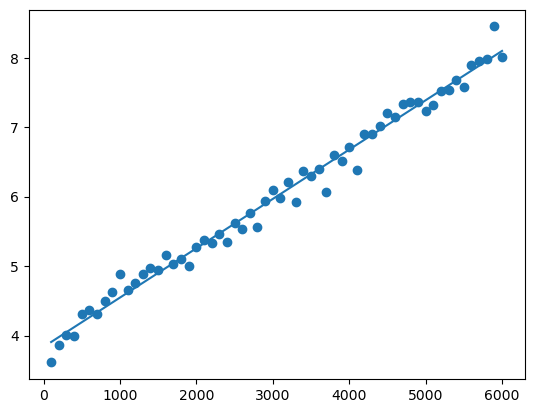

In [13]:
res = stats.linregress(N_range, times)
print(f"R-squared: {res.rvalue**2:.6f}")
plt.plot(N_range, res.intercept+N_range*res.slope, label='Linear fit')

plt.scatter(N_range, times, label='times')
plt.show()